In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import re
import glob
import math
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *
from datetime import datetime, timedelta
from collections import defaultdict
from multiprocessing import Manager

spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "9g") \
    .config("spark.executor.memory", "6g") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .appName('exploration') \
    .getOrCreate()

24/10/03 19:13:10 WARN Utils: Your hostname, Alans-MacBook-Air-4.local resolves to a loopback address: 127.0.0.1; using 192.168.0.52 instead (on interface en0)
24/10/03 19:13:10 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/03 19:13:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
transactions1 = spark.read.parquet("../data/transactions/transactions_20210228_20210827_snapshot")
transactions2 = spark.read.parquet("../data/transactions/transactions_20210828_20220227_snapshot")
transactions3 = spark.read.parquet("../data/transactions/transactions_20220228_20220828_snapshot")

transactions = transactions1.union(transactions2).union(transactions3)

transactions = transactions.withColumn('user_id', F.col('user_id').cast(StringType()))
transactions = transactions.withColumn('merchant_abn', F.col('merchant_abn').cast(StringType()))

transactions.show(truncate=False)

+-------+------------+------------------+------------------------------------+--------------+
|user_id|merchant_abn|dollar_value      |order_id                            |order_datetime|
+-------+------------+------------------+------------------------------------+--------------+
|18478  |62191208634 |63.255848959735246|949a63c8-29f7-4ab0-ada4-99ac50a88952|2021-08-20    |
|2      |15549624934 |130.3505283105634 |6a84c3cf-612a-4574-835b-144a47353eff|2021-08-20    |
|18479  |64403598239 |120.15860593212783|b10dcc33-e53f-4254-863c-de5266810cbc|2021-08-20    |
|3      |60956456424 |136.6785200286976 |0f09c5a5-784e-4477-b049-8ee4dd069b7b|2021-08-20    |
|18479  |94493496784 |72.96316578355305 |f6c78c1a-4600-4c5f-8e97-6e9eb534b586|2021-08-20    |
|3      |76819856970 |448.529684285612  |5ace6a24-cdf0-4aa3-b571-1d9406b352b5|2021-08-20    |
|18479  |67609108741 |86.4040605836911  |d0e180f0-cb06-42a3-bd1a-c47dca15bc55|2021-08-20    |
|3      |34096466752 |301.5793450525113 |6fb1ff48-24bb-4f97-

In [3]:
consumer_fraud = spark.read.option("header", True).csv("../data/tables/consumer_fraud_probability.csv")
consumer_fraud = consumer_fraud.withColumn('order_datetime', F.col('order_datetime').cast(DateType()))
consumer_fraud = consumer_fraud.withColumn('fraud_probability', F.col('fraud_probability').cast('double'))

consumer_details = spark.read.parquet("../data/tables/consumer_user_details.parquet")
consumer_details = consumer_details.withColumn('user_id', F.col('user_id').cast('string'))
consumer_details = consumer_details.withColumn('consumer_id', F.col('consumer_id').cast('string'))

merchant_fraud = spark.read.option("header", True).csv("../data/tables/merchant_fraud_probability.csv")
merchant_fraud = merchant_fraud.withColumnRenamed('fraud_probability', 'merchant_fraud_probability')
merchant_fraud = merchant_fraud.withColumn('merchant_fraud_probability', F.col('merchant_fraud_probability').cast('double'))

tbl_consumer = spark.read.option("header", True).option("delimiter", "|").csv("../data/tables/tbl_consumer.csv")

tbl_consumer = tbl_consumer.filter(F.col("state").isin(["NSW", "WA", "NT", "VIC", "TAS", "QLD", "SA",   "ACT"]))
tbl_consumer = tbl_consumer.filter(F.col("gender").isin(["Female", "Male", "Undisclosed"]))
tbl_consumer = tbl_consumer.withColumn("postcode", tbl_consumer["postcode"].cast(IntegerType()))
tbl_consumer = tbl_consumer.withColumnRenamed("name", "consumer_name")

In [4]:
tbl_merchants = spark.read.parquet("../data/tables/tbl_merchants.parquet")
tbl_merchants = tbl_merchants.withColumn('tags', F.regexp_replace('tags', r'\(', r'\[')) \
    .withColumn('tags', F.lower(F.regexp_replace('tags', r'\)', r'\]')))

tbl_merchants = tbl_merchants.withColumn('tags1', (F.regexp_extract('tags', r'\[\[([^\]]*)\][^\[]*\[([^\]]*)\][^\[]*\[take rate: ([^\]]*)\]\]', idx=1)))
tbl_merchants = tbl_merchants.withColumn('tags2', (F.regexp_extract('tags', r'\[\[([^\]]*)\][^\[]*\[([^\]]*)\][^\[]*\[take rate: ([^\]]*)\]\]', idx=2)))
tbl_merchants = tbl_merchants.withColumn('tags3', (F.regexp_extract('tags', r'\[\[([^\]]*)\][^\[]*\[([^\]]*)\][^\[]*\[take rate: ([^\]]*)\]\]', idx=3)).cast(DoubleType()))

tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), "\\s+", " "))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), ", except appliances", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), "rent al", "rental"))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), ":", ","))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " -", ","))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " shops", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " services", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " service", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " and", ","))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), ", sales", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), " ,", ","))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), ",,", ","))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), ",]", "]"))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), r"\[", ""))
tbl_merchants = tbl_merchants.withColumn("tags1", F.regexp_replace(F.col("tags1"), r"\]", ""))

tbl_merchants = tbl_merchants.withColumnRenamed('tags3', 'take_rate')
tbl_merchants = tbl_merchants.withColumnRenamed('tags2', 'type')
tbl_merchants = tbl_merchants.withColumnRenamed("name", "merchant_name")
tbl_merchants = tbl_merchants.drop('tags')
tbl_merchants = tbl_merchants.withColumnRenamed('tags1', 'tags')

tbl_merchants.show(truncate=False)

+------------------------------------+------------+----------------------------------------------------------------+----+---------+
|merchant_name                       |merchant_abn|tags                                                            |type|take_rate|
+------------------------------------+------------+----------------------------------------------------------------+----+---------+
|Felis Limited                       |10023283211 |furniture, home furnishings, equipment, manufacturers           |e   |0.18     |
|Arcu Ac Orci Corporation            |10142254217 |cable, satellite, other pay television, radio                   |b   |4.22     |
|Nunc Sed Company                    |10165489824 |jewelry, watch, clock, silverware                               |b   |4.4      |
|Ultricies Dignissim Lacus Foundation|10187291046 |watch, clock, jewelry repair                                    |b   |3.29     |
|Enim Condimentum PC                 |10192359162 |music, musical instrument

In [5]:
full_transactions = transactions.join(consumer_details, on="user_id",how="left") \
                   .join(tbl_consumer, on="consumer_id",how="left") \
                   .join(consumer_fraud, on=["user_id", "order_datetime"],how="left") \
                   .join(tbl_merchants, on="merchant_abn",how="left") \
                   .join(merchant_fraud, on=["order_datetime", "merchant_abn"], how="left")

full_transactions.show(truncate=False)

+--------------+------------+-------+-----------+-------------------+------------------------------------+---------------+--------------------------+-----+--------+------+-----------------+---------------------------------+----------------------------------------------------------------+----+---------+--------------------------+
|order_datetime|merchant_abn|user_id|consumer_id|dollar_value       |order_id                            |consumer_name  |address                   |state|postcode|gender|fraud_probability|merchant_name                    |tags                                                            |type|take_rate|merchant_fraud_probability|
+--------------+------------+-------+-----------+-------------------+------------------------------------+---------------+--------------------------+-----+--------+------+-----------------+---------------------------------+----------------------------------------------------------------+----+---------+--------------------------+
|2022-0

In [6]:
print(full_transactions.where(F.col("merchant_name").isNull()).count(), full_transactions.count())
full_transactions = full_transactions.where(F.col("merchant_name").isNotNull())
print(full_transactions.where(F.col("merchant_name").isNull()).count(), full_transactions.count())

580863 14195717


0 13614854


In [7]:
postcodes = gpd.read_file("../data/landing/POA_2021_AUST_GDA2020_SHP")
postcodes = postcodes.to_crs(epsg='4326')

postcodes['lon'] = postcodes.geometry.centroid.x
postcodes['lat'] = postcodes.geometry.centroid.y
postcodes = postcodes.drop(columns='geometry')
postcodes = postcodes.loc[:, ['POA_CODE21', 'AREASQKM21', 'SHAPE_Leng', 'SHAPE_Area', 'lon', 'lat']]
postcodes = postcodes.rename(columns={'POA_CODE21': 'postcode'})

postcodes = spark.createDataFrame(postcodes)

full_transactions = full_transactions.join(postcodes, on='postcode')
full_transactions.show(truncate=False)

/var/folders/xv/sxpnj6zd667gmqqstx378jj80000gn/T/ipykernel_85583/3306163271.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  postcodes['lon'] = postcodes.geometry.centroid.x
/var/folders/xv/sxpnj6zd667gmqqstx378jj80000gn/T/ipykernel_85583/3306163271.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  postcodes['lat'] = postcodes.geometry.centroid.y


+--------+--------------+------------+-------+-----------+------------------+------------------------------------+-------------+---------------+-----+------+-----------------+-----------------------------------+----------------------------------------------------------------+----+---------+--------------------------+----------+-------------+--------------+------------------+-------------------+
|postcode|order_datetime|merchant_abn|user_id|consumer_id|dollar_value      |order_id                            |consumer_name|address        |state|gender|fraud_probability|merchant_name                      |tags                                                            |type|take_rate|merchant_fraud_probability|AREASQKM21|SHAPE_Leng   |SHAPE_Area    |lon               |lat                |
+--------+--------------+------------+-------+-----------+------------------+------------------------------------+-------------+---------------+-----+------+-----------------+-----------------------------

In [8]:
# Combine the census data into a single dataframe, by postcode
# https://www.abs.gov.au/census/find-census-data/datapacks?release=2021&product=GCP&geography=SA2&header=S
TABLES = [
    '2021Census_G02_AUST_POA.csv',
    '2021Census_G04A_AUST_POA.csv',
    '2021Census_G04B_AUST_POA.csv'
]
POSTCODE_COLUMN = 'POA_CODE_2021'
SELECTED_COLUMNS = [
    POSTCODE_COLUMN,
    'Median_age_persons', 
    'Median_tot_fam_inc_weekly', 
    'Median_tot_hhd_inc_weekly', 
    'Average_household_size', 
    'Tot_M', 
    'Tot_P', 
    'Tot_F'
]

census_df = None
for table in TABLES:
    df = spark.read.options(header=True) \
        .csv(f"../data/landing/2021_GCP_POA_for_AUS_short-header/2021 Census GCP Postal Areas for AUS/{table}")

    if census_df is None:
        census_df = df
    else:
        census_df = census_df.join(df, POSTCODE_COLUMN).drop(df[POSTCODE_COLUMN])

census_df = census_df.withColumn(POSTCODE_COLUMN, F.regexp_replace(F.col(POSTCODE_COLUMN), "(\D)", ""))
census_df = census_df.select(*SELECTED_COLUMNS)
for column in SELECTED_COLUMNS[1:]:
    census_df = census_df.withColumn(column, F.col(column).cast(DoubleType()))
census_df = census_df.withColumnRenamed("POA_CODE_2021", "postcode")
census_df.show(truncate=False)

full_transactions = full_transactions.join(census_df, on='postcode', how="left")
full_transactions.show(truncate=False)

# census_df.summary().show()
# census_df.write.mode('overwrite').parquet('../data/raw/census2021.parquet')

+--------+------------------+-------------------------+-------------------------+----------------------+-------+-------+-------+
|postcode|Median_age_persons|Median_tot_fam_inc_weekly|Median_tot_hhd_inc_weekly|Average_household_size|Tot_M  |Tot_P  |Tot_F  |
+--------+------------------+-------------------------+-------------------------+----------------------+-------+-------+-------+
|2000    |32.0              |2367.0                   |2225.0                   |2.1                   |14223.0|27936.0|13713.0|
|2007    |30.0              |2197.0                   |1805.0                   |2.1                   |3763.0 |7410.0 |3644.0 |
|2008    |28.0              |2453.0                   |1746.0                   |1.9                   |5315.0 |10400.0|5083.0 |
|2009    |37.0              |3035.0                   |2422.0                   |2.1                   |6391.0 |12658.0|6267.0 |
|2010    |36.0              |3709.0                   |2297.0                   |1.7             

24/10/02 00:41:07 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+--------------+------------+-------+-----------+------------------+------------------------------------+-------------+---------------+-----+------+-----------------+-----------------------------------+----------------------------------------------------------------+----+---------+--------------------------+----------+-------------+--------------+------------------+-------------------+------------------+-------------------------+-------------------------+----------------------+-----+-----+-----+
|postcode|order_datetime|merchant_abn|user_id|consumer_id|dollar_value      |order_id                            |consumer_name|address        |state|gender|fraud_probability|merchant_name                      |tags                                                            |type|take_rate|merchant_fraud_probability|AREASQKM21|SHAPE_Leng   |SHAPE_Area    |lon               |lat                |Median_age_persons|Median_tot_fam_inc_weekly|Median_tot_hhd_inc_weekly|Average_household_size

In [9]:
retail_df = spark.read.parquet("../data/raw/retail_sales.parquet")
retail_df = retail_df.withColumn("month", F.month("date"))
retail_df = retail_df.withColumn("year", F.year("date"))
retail_df = retail_df.drop('date')
retail_df = retail_df.select([col for col in retail_df.columns if not col.endswith('trend')])
retail_df.show(truncate=False)

full_transactions = full_transactions.withColumn("month", F.month("order_datetime"))
full_transactions = full_transactions.withColumn("year", F.year("order_datetime"))
full_transactions = full_transactions.join(retail_df, on=['month', 'year'], how='left')
full_transactions.show(truncate=False)

+------------+------------+------------+-----------+-----------+------------+-----------+------------+--------------+------------+------------+------------+-----------+-----------+------------+-----------+------------+--------------+-----+----+
|NSW_original|VIC_original|QLD_original|SA_original|WA_original|TAS_original|NT_original|ACT_original|Total_original|NSW_seasonal|VIC_seasonal|QLD_seasonal|SA_seasonal|WA_seasonal|TAS_seasonal|NT_seasonal|ACT_seasonal|Total_seasonal|month|year|
+------------+------------+------------+-----------+-----------+------------+-----------+------------+--------------+------------+------------+------------+-----------+-----------+------------+-----------+------------+--------------+-----+----+
|1234.2      |887.0       |494.1       |277.2      |301.5      |77.5        |NULL       |55.3        |3357.8        |1309.8      |952.9       |518.6       |288.9      |321.2      |81.0        |NULL       |58.3        |3561.5        |6    |1982|
|1265.0      |921.3 

+-----+----+--------+--------------+------------+-------+-----------+------------------+------------------------------------+-------------+---------------+-----+------+-----------------+-----------------------------------+----------------------------------------------------------------+----+---------+--------------------------+----------+-------------+--------------+------------------+-------------------+------------------+-------------------------+-------------------------+----------------------+-----+-----+-----+------------+------------+------------+-----------+-----------+------------+-----------+------------+--------------+------------+------------+------------+-----------+-----------+------------+-----------+------------+--------------+
|month|year|postcode|order_datetime|merchant_abn|user_id|consumer_id|dollar_value      |order_id                            |consumer_name|address        |state|gender|fraud_probability|merchant_name                      |tags                     

In [ ]:
full_transactions.write.mode("overwrite").parquet("../data/curated/transactions.parquet")

[29.55524469 69.74088753 28.34260128 28.61547889 28.69020429 28.35387345
 30.57903216 29.05714322 29.53973321 28.50447905 30.23903245 27.93103068
 59.77648897 28.34828039 66.52282263 30.57903216 28.50447905 28.34140136
 29.16784078 29.55524469 30.02429183 28.8067089  28.35274652 28.50447905
 33.01471361 28.79521209 30.57903216 28.3373702  28.39941282 31.34350232
 28.50447905 31.34350232 28.3373702  30.57903216 29.75107524 28.78568573
 30.57903216 28.45905354 28.69020429 56.43761255 29.53973321 29.53973321
 29.08815812 30.02429183 29.85552419 29.55524469 30.57903216 28.65161761
 28.2815079  30.57903216 29.10401486 28.53232082 29.55524469 30.57903216
 30.23841986 28.20537898 29.53947304 32.49943591 30.57903216 28.50447905
 28.69020429 29.27259775 28.24267057 30.02429183 30.02429183 29.0263052
 29.05393297 28.8367477  31.48391056 28.34721657 28.50447905 30.57903216
 30.09158408 29.52661883 28.35898078 63.37734365 30.57903216 28.61661768
 30.57903216 28.95733256 28.10085623 31.02465578 28.

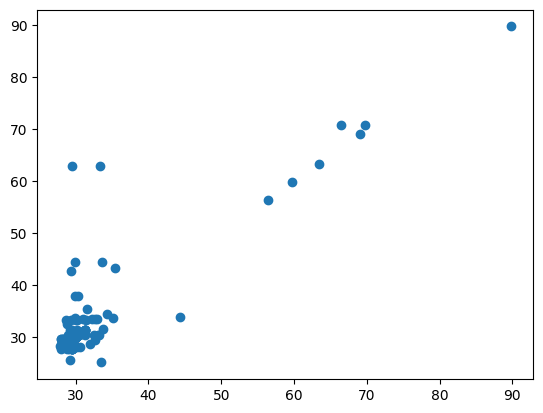

In [108]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

transactions = spark.read.parquet("../data/curated/transactions.parquet")

transactions = transactions.where(F.col("merchant_fraud_probability").isNotNull()).toPandas()

categories = transactions.select('tags').distinct().toPandas().dropna().astype("string")['tags'].to_list()

X = transactions.drop('merchant_fraud_probability', axis=1)
y = transactions['merchant_fraud_probability']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

columns = list(X.columns.values)

preprocessor = ColumnTransformer(
    transformers=[
        ('tags', Pipeline([
            ('onehot', OneHotEncoder(categories=[categories], sparse_output=False, handle_unknown='ignore')),
        ]), [columns.index('tags')]), # tags
        ('state', Pipeline([
            ('onehot', OneHotEncoder(categories=[['NSW', 'VIC', 'TAS', 'QLD', 'WA', 'SA', 'NT', 'ACT']], sparse_output=False, handle_unknown='ignore')),
        ]), [columns.index('state')]), # state
        ('dollar_value', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
        ]), [columns.index('dollar_value')]), # dollar value
        ('take_rate', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
        ]), [columns.index('take_rate')]) # take rate
    ]
)

knn = KNeighborsRegressor(n_neighbors=3, weights='distance', p=1)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', knn)
])

pipeline.fit(X_train, y_train)

# Display graph of predicted vs actual
plt.scatter(pipeline.predict(X_test), y_test)
print(f"RMSE: {root_mean_squared_error(y_test, pipeline.predict(X_test))}")

In [115]:
pipeline.fit(X, y)
transactions = pd.read_parquet("../data/curated/transactions.parquet")

mask = transactions['merchant_fraud_probability'].isna()

transactions_to_predict = transactions.loc[mask, :]
X_to_predict = transactions_to_predict.drop('merchant_fraud_probability', axis=1)

transactions.loc[mask, 'merchant_fraud_probability'] = pipeline.predict(X_to_predict)
transactions.to_parquet("../data/curated/transactions1.parquet")

24/10/02 17:25:14 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


RMSE: 7.446657155732339


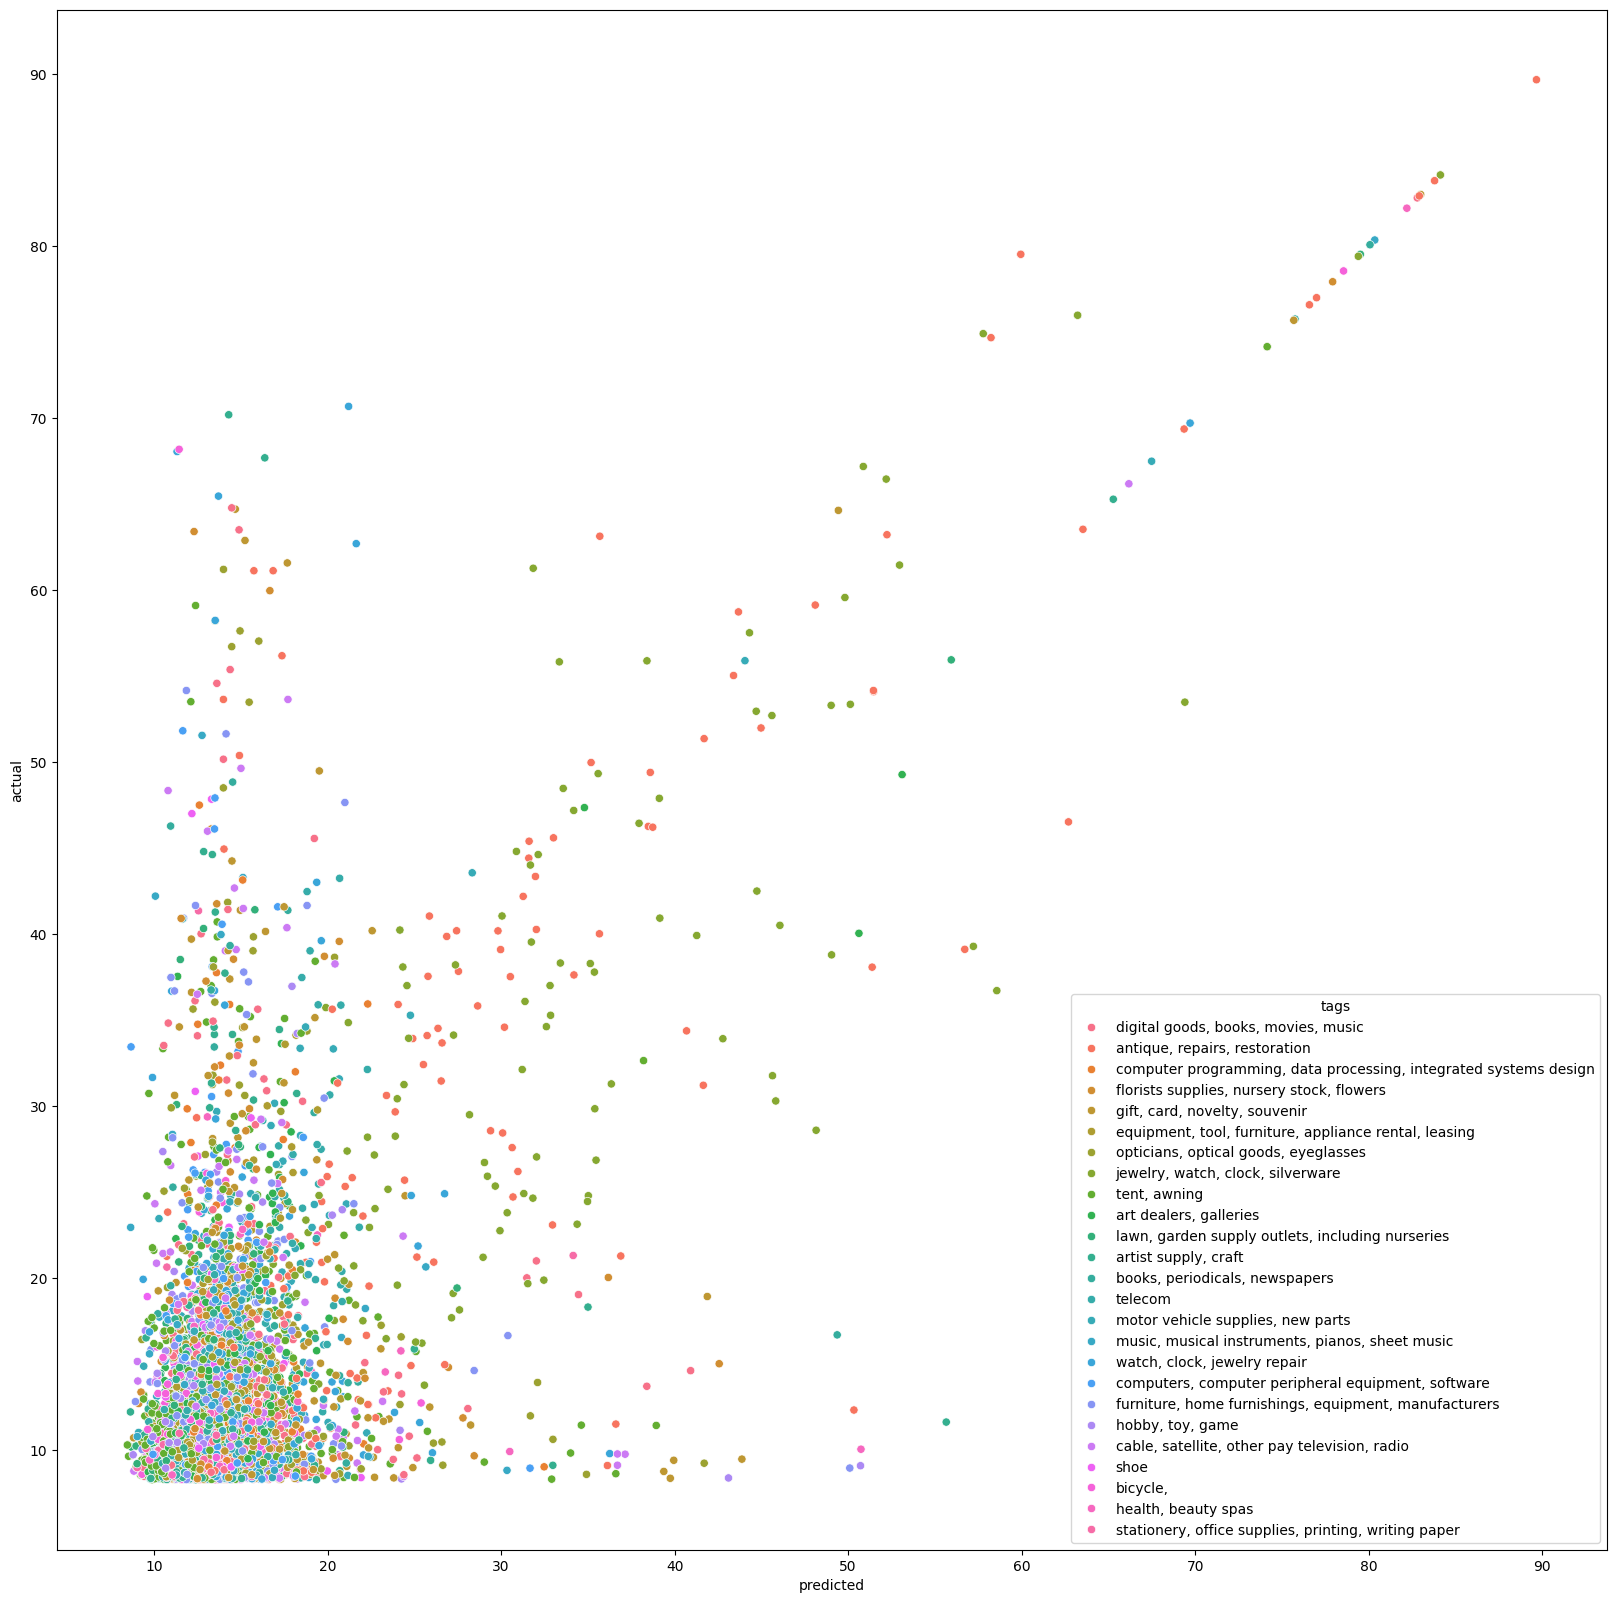

In [2]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

transactions = spark.read.parquet("../data/curated/transactions1.parquet")

categories = transactions.select('tags').distinct().toPandas().dropna().astype("string")['tags'].to_list()
transactions = transactions.where(F.col("fraud_probability").isNotNull()).toPandas()

X = transactions.drop('fraud_probability', axis=1)
y = transactions['fraud_probability']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

columns = list(X.columns.values)

preprocessor = ColumnTransformer(
    transformers=[
        ('tags', Pipeline([
            ('onehot', OneHotEncoder(categories=[categories], sparse_output=False, handle_unknown='ignore')),
        ]), [columns.index('tags')]), # tags
        ('state', Pipeline([
            ('onehot', OneHotEncoder(categories=[['NSW', 'VIC', 'TAS', 'QLD', 'WA', 'SA', 'NT', 'ACT']], sparse_output=False, handle_unknown='ignore')),
        ]), [columns.index('state')]), # state
        ('dollar_value', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
        ]), [columns.index('dollar_value')]), # dollar value
        ('take_rate', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
        ]), [columns.index('take_rate')]) # take rate
    ]
)

knn = KNeighborsRegressor(n_neighbors=int(math.sqrt(len(transactions)) / 2), weights='distance', p=1)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', knn)
])

X = transactions.drop('fraud_probability', axis=1)
y = transactions['fraud_probability']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

pipeline.fit(X_train, y_train)

combined = X_test
combined['predicted'] = pipeline.predict(X_test)
combined['actual'] = y_test
plt.figure(figsize=(20, 20))
sns.scatterplot(combined, x='predicted', y='actual', hue='tags')

print(f"RMSE: {root_mean_squared_error(y_test, pipeline.predict(X_test))}")

In [12]:
# pipeline.fit(X, y)
# print("Fitted pipeline")
# transactions = pd.read_parquet("../data/curated/transactions1.parquet")

# mask = transactions['fraud_probability'].isna()

# transactions_to_predict = transactions.loc[mask, :]
# X_to_predict = transactions_to_predict.drop('fraud_probability', axis=1)

# transactions.loc[mask, 'fraud_probability'] = pipeline.predict(X_to_predict)
# transactions.to_parquet("../data/curated/transactions2.parquet")

In [3]:
import pandas as pd

# Fit your pipeline
pipeline.fit(X, y)
print("Fitted pipeline")

# Load transactions
transactions = pd.read_parquet("../data/curated/transactions1.parquet")

mask = transactions['fraud_probability'].isna()
transactions_to_predict = transactions.loc[mask, :]
X_to_predict = transactions_to_predict.drop('fraud_probability', axis=1)

batch_size = 50000

i = 0
for start in range(0, X_to_predict.shape[0], batch_size):
    end = min(start + batch_size, X_to_predict.shape[0])
    batch = X_to_predict.iloc[start:end]
    
    preds = pipeline.predict(batch)
    
    print(f"Finished batch {i}")
    i += 1

    indices_to_update = transactions.loc[mask].index[start:end]
    transactions.loc[indices_to_update, 'fraud_probability'] = preds

    # print(transactions.loc[mask, 'fraud_probability'].iloc[start:end])

transactions.to_parquet("../data/curated/transactions2.parquet")


Fitted pipeline
Finished batch 0
Finished batch 1
Finished batch 2
Finished batch 3
Finished batch 4
Finished batch 5
Finished batch 6
Finished batch 7
Finished batch 8
Finished batch 9
Finished batch 10
Finished batch 11
Finished batch 12
Finished batch 13
Finished batch 14
Finished batch 15
Finished batch 16
Finished batch 17
Finished batch 18
Finished batch 19
Finished batch 20
Finished batch 21
Finished batch 22
Finished batch 23
Finished batch 24
Finished batch 25
Finished batch 26
Finished batch 27
Finished batch 28
Finished batch 29
Finished batch 30
Finished batch 31
Finished batch 32
Finished batch 33
Finished batch 34
Finished batch 35
Finished batch 36
Finished batch 37
Finished batch 38
Finished batch 39
Finished batch 40
Finished batch 41
Finished batch 42
Finished batch 43
Finished batch 44
Finished batch 45
Finished batch 46
Finished batch 47
Finished batch 48
Finished batch 49
Finished batch 50
Finished batch 51
Finished batch 52
Finished batch 53
Finished batch 54
Fini

In [4]:
full_transactions = spark.read.parquet("../data/curated/transactions2.parquet")
full_transactions.show(truncate=False)

+-----+----+--------+--------------+------------+-------+-----------+------------------+------------------------------------+-------------+---------------+-----+------+------------------+-----------------------------------+----------------------------------------------------------------+----+---------+--------------------------+----------+-------------+--------------+------------------+-------------------+------------------+-------------------------+-------------------------+----------------------+-----+-----+-----+------------+------------+------------+-----------+-----------+------------+-----------+------------+--------------+------------+------------+------------+-----------+-----------+------------+-----------+------------+--------------+
|month|year|postcode|order_datetime|merchant_abn|user_id|consumer_id|dollar_value      |order_id                            |consumer_name|address        |state|gender|fraud_probability |merchant_name                      |tags                   

In [4]:
# Add features to get transactions ready to pass to model
transactions = spark.read.parquet("../data/curated/transactions2.parquet")
transactions = transactions.withColumn('expected_revenue', 
                                       transactions.dollar_value
                                       * (1.0 - transactions.merchant_fraud_probability / 100.0) 
                                       * (1.0 - transactions.fraud_probability / 100.0) 
                                       * transactions.take_rate / 100.0)
transactions = transactions.withColumn('day_of_week', F.dayofweek('order_datetime'))
transactions = transactions.withColumn('day_of_month', F.dayofmonth('order_datetime'))
transactions = transactions.withColumn('month', F.month('order_datetime'))

transactions = transactions.withColumn(
    "seasonal_sales",
    F.when(F.col("state") == "NSW", F.col("NSW_seasonal"))
     .when(F.col("state") == "VIC", F.col("VIC_seasonal"))
     .when(F.col("state") == "QLD", F.col("QLD_seasonal"))
     .when(F.col("state") == "SA", F.col("SA_seasonal"))
     .when(F.col("state") == "WA", F.col("WA_seasonal"))
     .when(F.col("state") == "TAS", F.col("TAS_seasonal"))
     .when(F.col("state") == "NT", F.col("NT_seasonal"))
     .when(F.col("state") == "ACT", F.col("ACT_seasonal"))
     .otherwise(None)
)

transactions = transactions.withColumn(
    "original_sales",
    F.when(F.col("state") == "NSW", F.col("NSW_original"))
     .when(F.col("state") == "VIC", F.col("VIC_original"))
     .when(F.col("state") == "QLD", F.col("QLD_original"))
     .when(F.col("state") == "SA", F.col("SA_original"))
     .when(F.col("state") == "WA", F.col("WA_original"))
     .when(F.col("state") == "TAS", F.col("TAS_original"))
     .when(F.col("state") == "NT", F.col("NT_original"))
     .when(F.col("state") == "ACT", F.col("ACT_original"))
     .otherwise(None)
)

transactions = transactions.select([col for col in transactions.columns if not col.endswith('original')])
transactions = transactions.select([col for col in transactions.columns if not col.endswith('seasonal')])

transactions.write.mode('overwrite').parquet("../data/curated/transactions3.parquet")
transactions.show(truncate=False)

+-----+----+--------+--------------+------------+-------+-----------+------------------+------------------------------------+-------------+---------------+-----+------+------------------+-----------------------------------+----------------------------------------------------------------+----+---------+--------------------------+----------+-------------+--------------+------------------+-------------------+------------------+-------------------------+-------------------------+----------------------+-----+-----+-----+--------------------+-----------+------------+--------------+--------------+
|month|year|postcode|order_datetime|merchant_abn|user_id|consumer_id|dollar_value      |order_id                            |consumer_name|address        |state|gender|fraud_probability |merchant_name                      |tags                                                            |type|take_rate|merchant_fraud_probability|AREASQKM21|SHAPE_Leng   |SHAPE_Area    |lon               |lat          

In [6]:
import torch
import torch.nn as nn


# embed_dim is maximum embedding size
class TimeSeriesTransformer(nn.Module):
    def __init__(self, categorical_vars, embed_dim, d_model, num_numerical, nhead, num_layers, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        
        self.embeddings = []
        embedding_dim = 0
        for num_categories in categorical_vars:
            self.embeddings.append(nn.Embedding(num_categories, min(embed_dim, num_categories)))
            embedding_dim += min(embed_dim, num_categories)
        self.embeddings = nn.ModuleList(self.embeddings)

        self.linear_cont = nn.Linear(num_numerical, d_model - embedding_dim)  # for `fraud_probability` and `revenue`
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.fc_out = nn.Linear(d_model, 7)  # 7 days prediction

    def forward(self, categorical_vars, cont_features):
        embeddings = []
        for i, value in enumerate(categorical_vars):
            embeddings.append(self.embeddings[i](value))
        
        cont_emb = self.linear_cont(cont_features)
        x = torch.cat(embeddings + [cont_emb], dim=-1)
        x = x.transpose(0, 1)
        
        x = self.transformer(x)
        x = x.transpose(0, 1)

        x = x[:, -1, :]
        
        return self.fc_out(x)


"\n# Generating synthetic data for 30 days\nmerchant_ids = [1, 2, 3]  # Example merchant ids\npostcodes = [1, 2, 3]  # Example postcodes\n\n# Create data for 30 days\ndata = {\n    'merchant_id': np.random.choice(merchant_ids, size=30),\n    'postcode': np.random.choice(postcodes, size=30),\n    'fraud_probability': np.random.rand(30),  # Random values between 0 and 1\n    'revenue': np.random.rand(30) * 1000,     # Random revenue between 0 and 1000\n    'target_revenue': np.random.rand(7) * 1000  # Random target revenue for next 7 days\n}\n"

In [10]:
from sklearn.preprocessing import LabelEncoder

transactions = pd.read_parquet('../data/curated/transactions3.parquet')
transactions = transactions.sort_values(by='order_datetime', axis=0)
# transactions = transactions[transactions['merchant_abn'].isin([
#     "24852446429",
# ])]

EMBEDDING_COLUMNS = ['merchant_abn', 'postcode', 'state', 'gender', 'tags', 'day_of_week', 'day_of_month', 'month', 'year']
NUMERICAL_COLUMNS = ['dollar_value', 'seasonal_sales', 'expected_revenue', 'Tot_P', 'Median_tot_hhd_inc_weekly']

embedding_encoders = {col: LabelEncoder() for col in EMBEDDING_COLUMNS}
for col, encoder in embedding_encoders.items():
    transactions[col] = encoder.fit_transform(transactions[col])

transactions.head()

model = TimeSeriesTransformer([len(embedding_encoders[col].classes_) for col in EMBEDDING_COLUMNS], 32, 256, len(NUMERICAL_COLUMNS), 4, 3)
# model()

/Users/alanlu/Library/CloudStorage/OneDrive-TheUniversityofMelbourne/documents/2024/MAST30034/proj2/project-2-group-buy-now-pay-later-industry-project-30/.venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [11]:
# print(transactions[['order_datetime'] + NUMERICAL_COLUMNS + EMBEDDING_COLUMNS])

# df = transactions[['order_datetime'] + NUMERICAL_COLUMNS + EMBEDDING_COLUMNS]
df = transactions

import pandas as pd
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

def save_model(model, file_path):
    torch.save({
        'model_state_dict': model.state_dict(),
        # Optionally save the optimizer state if needed
        # 'optimizer_state_dict': optimizer.state_dict(),
    }, file_path)

def load_model(file_path, categorical_vars, embed_dim, d_model, num_numerical, nhead, num_layers, dropout=0.1):
    model = TimeSeriesTransformer(categorical_vars, embed_dim, d_model, num_numerical, nhead, num_layers, dropout)
    checkpoint = torch.load(file_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

df['order_datetime'] = pd.to_datetime(df['order_datetime'])
df = df.sort_values(by=['merchant_abn', 'order_datetime'])

class TimeSeriesDataset(Dataset):
    def __init__(self, dataframe, input_days=30, output_days=7):
        self.dataframe = dataframe
        self.input_days = input_days
        self.output_days = output_days
        self.groups = self.dataframe.groupby('merchant_abn')

    def __len__(self):
        total_length = 0
        for _, group in self.groups:
            total_length += len(group) - self.input_days - self.output_days + 1
        return total_length

    def __getitem__(self, index):
        for merchant_abn, group in self.groups:
            if index < len(group) - self.input_days - self.output_days + 1:
                input_data = group.iloc[index:index + self.input_days]
                output_data = group.iloc[index + self.input_days:index + self.input_days + self.output_days]

                categorical_vars = [torch.tensor(input_data[col].values, dtype=torch.long) for col in EMBEDDING_COLUMNS]
                continuous_inputs = torch.tensor(input_data[NUMERICAL_COLUMNS].values, dtype=torch.float32)
                continuous_outputs = torch.tensor(output_data[['expected_revenue']].values, dtype=torch.float32)  # Change to the appropriate output feature

                return categorical_vars, continuous_inputs, continuous_outputs

            index -= len(group) - self.input_days - self.output_days + 1

dataset = TimeSeriesDataset(df)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    i = 0
    total_loss = 0
    for categorical_vars, cont_inputs, cont_outputs in dataloader:
        categorical_vars = [var.to(device) for var in categorical_vars]
        cont_inputs = cont_inputs.to(device)
        cont_outputs = cont_outputs.to(device)

        optimizer.zero_grad()
        outputs = model(categorical_vars, cont_inputs)
        
        print(outputs.shape, cont_outputs.shape)
        
        loss = loss_fn(outputs, cont_outputs.squeeze())  # Assuming cont_outputs is shaped (batch_size, 7)
        loss.backward()
        
        optimizer.step()

        total_loss += loss.item()
        print(i, loss, end=' ')
        
        if i % 100 == 0:
            save_model(model, f'model_checkpoint_epoch{epoch+1}_iter{i}.pth')
            print(f'Saved model checkpoint at iteration {i}')
        
        i += 1

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader):.4f}')

print("Training completed.")

torch.Size([32, 7]) torch.Size([32, 7, 1])
0 tensor(161429.4062, grad_fn=<MseLossBackward0>) Saved model checkpoint at iteration 0
torch.Size([32, 7]) torch.Size([32, 7, 1])
1 tensor(80556.8516, grad_fn=<MseLossBackward0>) torch.Size([32, 7]) torch.Size([32, 7, 1])
2 tensor(113194.3281, grad_fn=<MseLossBackward0>) torch.Size([32, 7]) torch.Size([32, 7, 1])
3 tensor(81680.1172, grad_fn=<MseLossBackward0>) torch.Size([32, 7]) torch.Size([32, 7, 1])
4 tensor(127290.6328, grad_fn=<MseLossBackward0>) torch.Size([32, 7]) torch.Size([32, 7, 1])
5 tensor(185569.2344, grad_fn=<MseLossBackward0>) torch.Size([32, 7]) torch.Size([32, 7, 1])
6 tensor(217242.3438, grad_fn=<MseLossBackward0>) torch.Size([32, 7]) torch.Size([32, 7, 1])
7 tensor(135403.4062, grad_fn=<MseLossBackward0>) torch.Size([32, 7]) torch.Size([32, 7, 1])
8 tensor(109573.5469, grad_fn=<MseLossBackward0>) torch.Size([32, 7]) torch.Size([32, 7, 1])
9 tensor(71815.2578, grad_fn=<MseLossBackward0>) torch.Size([32, 7]) torch.Size([32,

24/10/03 09:45:47 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 907153 ms exceeds timeout 120000 ms
24/10/03 09:45:47 WARN SparkContext: Killing executors is not supported by current scheduler.
24/10/03 09:45:48 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

torch.Size([32, 7]) torch.Size([32, 7, 1])
488 tensor(119327.5625, grad_fn=<MseLossBackward0>) 

24/10/03 09:46:08 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

torch.Size([32, 7]) torch.Size([32, 7, 1])
489 tensor(197224.7969, grad_fn=<MseLossBackward0>) 

24/10/03 10:26:58 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

torch.Size([32, 7]) torch.Size([32, 7, 1])
490 tensor(68466.4375, grad_fn=<MseLossBackward0>) 

24/10/03 10:28:38 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

torch.Size([32, 7]) torch.Size([32, 7, 1])
491 tensor(97273.2969, grad_fn=<MseLossBackward0>) 

24/10/03 10:30:38 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

torch.Size([32, 7]) torch.Size([32, 7, 1])
492 tensor(109716.8125, grad_fn=<MseLossBackward0>) 

24/10/03 10:32:38 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

torch.Size([32, 7]) torch.Size([32, 7, 1])
493 tensor(137777.2500, grad_fn=<MseLossBackward0>) 

24/10/03 10:33:58 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

torch.Size([32, 7]) torch.Size([32, 7, 1])
494 tensor(133977.1094, grad_fn=<MseLossBackward0>) torch.Size([32, 7]) torch.Size([32, 7, 1])
495 tensor(57296.2070, grad_fn=<MseLossBackward0>) torch.Size([32, 7]) torch.Size([32, 7, 1])
496 tensor(263742.2188, grad_fn=<MseLossBackward0>) torch.Size([32, 7]) torch.Size([32, 7, 1])
497 tensor(199551.4531, grad_fn=<MseLossBackward0>) torch.Size([32, 7]) torch.Size([32, 7, 1])
498 tensor(112868.1016, grad_fn=<MseLossBackward0>) torch.Size([32, 7]) torch.Size([32, 7, 1])
499 tensor(63864.4570, grad_fn=<MseLossBackward0>) torch.Size([32, 7]) torch.Size([32, 7, 1])
500 tensor(156557.4062, grad_fn=<MseLossBackward0>) Saved model checkpoint at iteration 500
torch.Size([32, 7]) torch.Size([32, 7, 1])
501 tensor(90178.1250, grad_fn=<MseLossBackward0>) torch.Size([32, 7]) torch.Size([32, 7, 1])
502 tensor(120847.2734, grad_fn=<MseLossBackward0>) torch.Size([32, 7]) torch.Size([32, 7, 1])
503 tensor(152631.0312, grad_fn=<MseLossBackward0>) 

KeyboardInterrupt: 

In [70]:
output.shape

torch.Size([32, 30, 7])

In [62]:
print(transactions[['order_datetime'] + NUMERICAL_COLUMNS + EMBEDDING_COLUMNS])

        order_datetime  dollar_value  seasonal_sales  expected_revenue  \
6422708     2021-02-28     14.340288          6384.9         24.211544   
479594      2021-02-28      7.347797          7588.6         34.117571   
5176499     2021-02-28     20.542863          3271.9         26.505217   
479593      2021-02-28     11.489780          7588.6         22.462932   
2649321     2021-02-28     65.007820          9650.9        279.023956   
...                ...           ...             ...               ...   
6883400     2022-10-26    108.746157          7245.2        185.371798   
7893083     2022-10-26      0.594258          9056.5          2.759282   
4375021     2022-10-26     34.541920          3873.2         44.549967   
1168577     2022-10-26      1.355671          7245.2          0.805636   
8328767     2022-10-26      7.940673         11073.9          6.301139   

           Tot_P  Median_tot_hhd_inc_weekly  merchant_abn  postcode  state  \
6422708    211.0                 

In [28]:
transactions.groupBy('merchant_abn').count().sort(F.col("count").desc()).where(F.col("count") > 10000).select("count").groupBy().sum().collect()

[Row(sum(count)=7139839)]

In [30]:
transactions.groupBy('merchant_abn').count().sort(F.col("count").desc()).where(F.col("count") > 10000).show(1000)

+------------+------+
|merchant_abn| count|
+------------+------+
| 24852446429|241506|
| 86578477987|227775|
| 64203420245|217571|
| 49891706470|206878|
| 46804135891|195655|
| 45629217853|190768|
| 89726005175|180185|
| 43186523025|167852|
| 80324045558|164419|
| 63290521567|152022|
| 68216911708|151084|
| 21439773999|100748|
| 64403598239| 94850|
| 72472909171| 85195|
| 94493496784| 82896|
| 79417999332| 82822|
| 60956456424| 75848|
| 32361057556| 71720|
| 91923722701| 65339|
| 49505931725| 57037|
| 96152467973| 56695|
| 19933438190| 56660|
| 57900494384| 55926|
| 48534649627| 55666|
| 17324645993| 54436|
| 82065156333| 53933|
| 20985347699| 52118|
| 47086412084| 45682|
| 98973094975| 45647|
| 49322182190| 43432|
| 38090089066| 43296|
| 81219314324| 42086|
| 62694031334| 40537|
| 98269572896| 38137|
| 35223308778| 37439|
| 11566786699| 37411|
| 75944642726| 37309|
| 29616684420| 36967|
| 76767266140| 36303|
| 52959528548| 35539|
| 84703983173| 35384|
| 46298404088| 34804|
| 41251795

In [31]:

transactions.groupBy('merchant_abn').count().sort(F.col("count").desc()).where(F.col("count") > 10000).count()

239

In [36]:
transactions.show()

+-----+----+--------+--------------+------------+-------+-----------+------------------+--------------------+-------------+---------------+-----+------+------------------+--------------------+--------------------+----+---------+--------------------------+----------+-------------+--------------+------------------+-------------------+------------------+-------------------------+-------------------------+----------------------+-----+-----+-----+------------------+-----------+------------+--------------+--------------+
|month|year|postcode|order_datetime|merchant_abn|user_id|consumer_id|      dollar_value|            order_id|consumer_name|        address|state|gender| fraud_probability|       merchant_name|                tags|type|take_rate|merchant_fraud_probability|AREASQKM21|   SHAPE_Leng|    SHAPE_Area|               lon|                lat|Median_age_persons|Median_tot_fam_inc_weekly|Median_tot_hhd_inc_weekly|Average_household_size|Tot_M|Tot_P|Tot_F|  expected_revenue|day_of_week|da

In [6]:
transactions = spark.read.parquet("../data/curated/transactions3.parquet")
# transactions.show()

In [7]:
from pyspark.sql.window import Window
from pyspark.sql import DataFrame

def skewness_udf(column):
    return (F.mean(column) - F.median(column)) / F.stddev(column)

window_spec = Window.partitionBy("merchant_abn").orderBy("order_datetime")

agg_df = transactions.groupBy("merchant_abn").agg(
    F.expr("percentile_approx(fraud_probability, 0.5)").alias("fraud_probability_median"),
    skewness_udf(F.col("fraud_probability")).alias("fraud_probability_skewness"),
    F.expr("percentile_approx(dollar_value, 0.5)").alias("dollar_value_median"),
    F.expr("percentile_approx(expected_revenue, 0.5)").alias("expected_revenue_median"),
    skewness_udf(F.col("dollar_value")).alias("dollar_value_skewness"),
    F.count("merchant_abn").alias("record_count"),
    F.first("tags").alias("tags"),
    F.first("take_rate").alias("take_rate"),
    F.mean("merchant_fraud_probability").alias("merchant_fraud_probability")
)

agg_df.show()

+------------+------------------------+--------------------------+-------------------+-----------------------+---------------------+------------+--------------------+---------+--------------------------+
|merchant_abn|fraud_probability_median|fraud_probability_skewness|dollar_value_median|expected_revenue_median|dollar_value_skewness|record_count|                tags|take_rate|merchant_fraud_probability|
+------------+------------------------+--------------------------+-------------------+-----------------------+---------------------+------------+--------------------+---------+--------------------------+
| 10441711491|      13.981469844702758|       0.38977680993708874|  4184.883294138098|     146.31870423556205|  0.45060052621274055|           3|motor vehicle sup...|     5.77|        29.555244690425017|
| 10487253336|      13.091596850582814|       0.20436084454253342| 359.87222862385426|      7.375452844543792|   0.2496038054530237|        2113|artist supply, craft|     3.92|        

In [9]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

df = agg_df.toPandas()
df = df.fillna(0)
df['record_count'] = np.log(df['record_count'])
# df['dollar_value_median'] = np.log(df['dollar_value_median'])
df['expected_revenue_median'] = np.log(df['expected_revenue_median'])
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=3, random_state=0))
])

df['cluster'] = pipeline.fit_predict(df[['record_count', 'merchant_fraud_probability', 'expected_revenue_median']])

fig = px.scatter(
    df, 
    x='record_count', 
    y='expected_revenue_median', 
    color='cluster', 
    title='log(median expected revenue) vs log(sales) by KMeans Cluster', 
    labels={
        'record_count': 'log(sales)',
        'expected_revenue_median': 'log(median expected revenue)'
    },
    hover_data=['merchant_abn']
)

fig.show()

In [10]:
fig = px.scatter(
    df, 
    x='record_count', 
    y='expected_revenue_median', 
    color='tags', 
    title='log(median expected revenue) vs log(sales) by KMeans Cluster', 
    labels={
        'record_count': 'log(sales)',
        'expected_revenue_median': 'log(median expected revenue)'
    },
    hover_data=['merchant_abn']
)

# Display plot
fig.show()

# Presentation
1. Problem overview - how to choose best merchants, which segments of merchants to take from
2. Preprocessing data steps - removal of outliers
3. Interesting merchants - weird distributions
4. Fraud imputing values, took average fraud
5. Creating model to rank
6. Segmentation
7. Further actions - limitations, assumptions

In [ ]:
# Get distributions for tags after clusters
# Create SARIMAX model



In [84]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

transactions = spark.read.parquet("../data/curated/transactions3.parquet")
# transactions.show()

# transactions.groupBy("order_datetime", "merchant_abn").count().sort(F.col('count').desc()).show(1000)
max_per_day = transactions.groupBy("order_datetime", "merchant_abn").count().groupBy().max().collect()[0][0]

# transactions = transactions.where(F.col('merchant_abn') == '24852446429')
# transactions = transactions.where(F.col('merchant_abn') == '86578477987')
transactions = transactions.where(F.col('merchant_abn') == '11791943985')
transactions = transactions.groupBy('order_datetime').agg(
    F.sum('expected_revenue').alias('expected_revenue')
)

transactions = transactions.toPandas()

order = (1, 0, 1)
seasonal_order = (0, 1, 1, 7)

model = SARIMAX(transactions['expected_revenue'], 
                order=order, 
                seasonal_order=seasonal_order)

results = model.fit(disp=False)

print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                  expected_revenue   No. Observations:                  506
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 7)   Log Likelihood               -1678.173
Date:                           Thu, 03 Oct 2024   AIC                           3364.347
Time:                                   23:15:39   BIC                           3381.197
Sample:                                        0   HQIC                          3370.959
                                           - 506                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2546      0.646      0.394      0.693      -1.011       1.520
ma.L1         -0.3210      0.637     -0.504

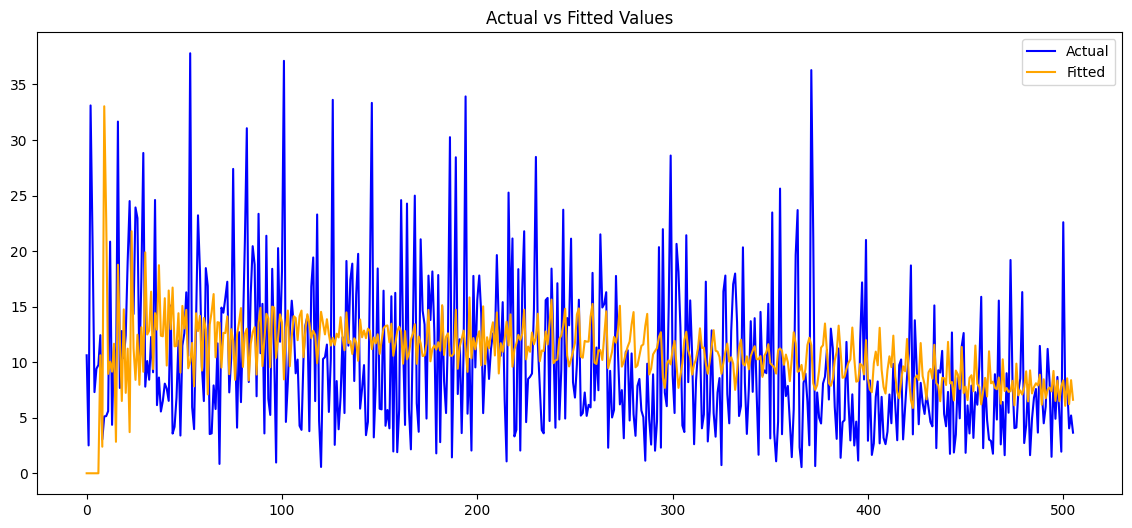

In [85]:
plt.figure(figsize=(14, 6))
plt.plot(transactions['expected_revenue'], label='Actual', color='blue')
plt.plot(results.fittedvalues, label='Fitted', color='orange')
plt.title('Actual vs Fitted Values')
plt.legend()
plt.show()

In [83]:
transactions = spark.read.parquet("../data/curated/transactions3.parquet")
# transactions.show()

# transactions.groupBy("order_datetime", "merchant_abn").count().sort(F.col('count').desc()).show(1000)

+-----+----+--------+--------------+------------+-------+-----------+------------------+--------------------+----------------+---------------+-----+-----------+------------------+--------------------+--------------------+----+---------+--------------------------+----------+---------------+----------------+------------------+------------------+------------------+-------------------------+-------------------------+----------------------+-----+------+-----+-------------------+-----------+------------+--------------+--------------+
|month|year|postcode|order_datetime|merchant_abn|user_id|consumer_id|      dollar_value|            order_id|   consumer_name|        address|state|     gender| fraud_probability|       merchant_name|                tags|type|take_rate|merchant_fraud_probability|AREASQKM21|     SHAPE_Leng|      SHAPE_Area|               lon|               lat|Median_age_persons|Median_tot_fam_inc_weekly|Median_tot_hhd_inc_weekly|Average_household_size|Tot_M| Tot_P|Tot_F|   expec

+--------------+------------+-----+
|order_datetime|merchant_abn|count|
+--------------+------------+-----+
|    2021-11-26| 24852446429| 1053|
|    2021-11-27| 24852446429|  982|
|    2021-11-29| 24852446429|  963|
|    2021-11-27| 86578477987|  944|
|    2021-11-26| 86578477987|  942|
|    2021-11-26| 64203420245|  935|
|    2021-11-26| 49891706470|  921|
|    2021-11-29| 86578477987|  914|
|    2021-11-29| 64203420245|  894|
|    2021-11-26| 46804135891|  870|
|    2021-11-26| 45629217853|  854|
|    2021-11-27| 49891706470|  843|
|    2021-11-29| 49891706470|  814|
|    2021-11-27| 64203420245|  803|
|    2021-11-27| 46804135891|  801|
|    2021-11-28| 24852446429|  796|
|    2021-11-27| 45629217853|  791|
|    2021-11-29| 45629217853|  786|
|    2021-11-29| 46804135891|  776|
|    2021-12-26| 24852446429|  767|
|    2021-11-28| 64203420245|  767|
|    2021-11-27| 89726005175|  751|
|    2021-11-26| 43186523025|  750|
|    2021-11-30| 24852446429|  744|
|    2021-11-30| 86578477987

In [36]:
transactions

,order_datetime,expected_revenue
0,2021-12-18,195.013883
1,2022-03-28,135.630581
2,2021-06-22,122.342562
3,2021-08-27,148.032406
4,2022-07-31,150.357993
...,...,...
601,2022-08-31,153.469546
602,2021-05-13,121.162601
603,2021-04-12,102.300715
604,2021-04-10,116.189978


In [54]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(transactions['expected_revenue'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -26.381473975861237
p-value: 0.0


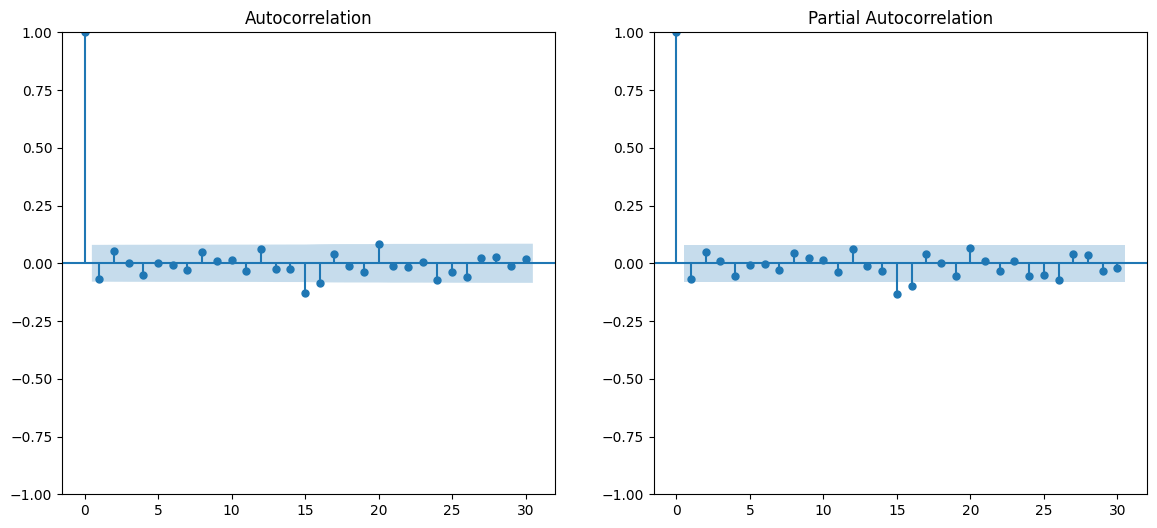

In [55]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
plot_acf(transactions['expected_revenue'], lags=30, ax=ax[0])
plot_pacf(transactions['expected_revenue'], lags=30, ax=ax[1])
plt.show()

<Axes: >

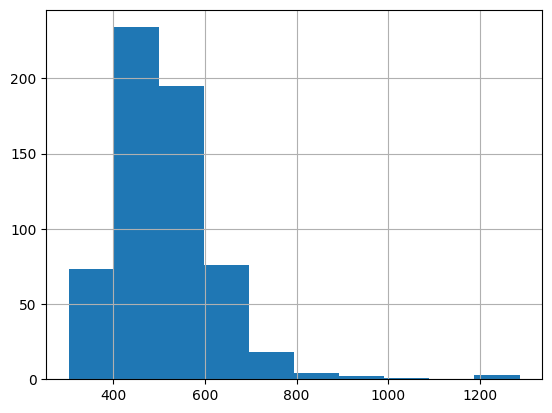

In [68]:
transactions['expected_revenue'].hist()

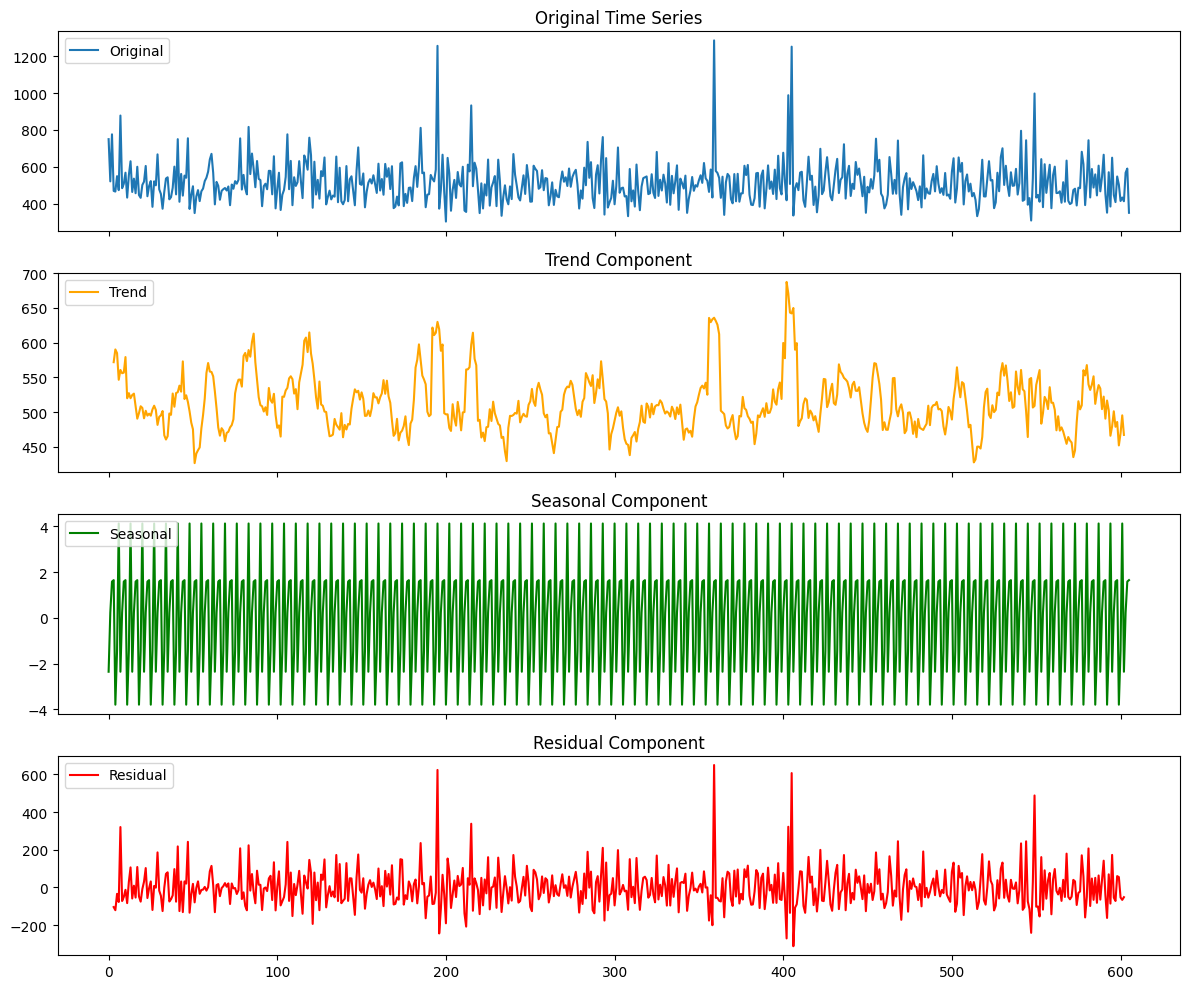

In [74]:
decomposition = sm.tsa.seasonal_decompose(transactions['expected_revenue'], model='additive', period=7)
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

axes[0].plot(transactions['expected_revenue'], label='Original')
axes[0].legend(loc='upper left')
axes[0].set_title('Original Time Series')

axes[1].plot(decomposition.trend, label='Trend', color='orange')
axes[1].legend(loc='upper left')
axes[1].set_title('Trend Component')

axes[2].plot(decomposition.seasonal, label='Seasonal', color='green')
axes[2].legend(loc='upper left')
axes[2].set_title('Seasonal Component')

axes[3].plot(decomposition.resid, label='Residual', color='red')
axes[3].legend(loc='upper left')
axes[3].set_title('Residual Component')

plt.tight_layout()
plt.show()

AttributeError: 'DataFrame' object has no attribute 'show'